In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC as SVMClassifier
from tools.preprocess import load_datasets, preprocess_hepatitis_datasets
from tools.distance import ManhattanDistance, EuclideanDistance
from tools.voting import MajorityClassVote, InverseDistanceWeightedVote, ShepardsWorkVote
from tools.knn import KNNClassifier
from tools.metrics import cross_validate
from tools.weighting import EqualWeighting, InformationGainWeighting, ReliefFWeighting
import itertools
from functools import partial
import logging

logging.basicConfig(level=logging.ERROR, format="%(levelname)s - %(message)s")
logger = logging.getLogger()

In [2]:
train_dfs = load_datasets("../data/raw/hepatitis/hepatitis.fold.*.train.arff")
test_dfs = load_datasets("../data/raw/hepatitis/hepatitis.fold.*.test.arff")

print(f"\nNumber of training dataframes: {len(train_dfs)}")
print(f"Number of test dataframes: {len(test_dfs)}")
print()
train_dfs[0].head()


Number of training dataframes: 10
Number of test dataframes: 10



,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,50.0,female,no,no,yes,no,no,no,no,no,no,no,no,0.9,135.0,42.0,3.5,NaN,no,LIVE
1,45.0,male,no,no,yes,yes,no,yes,no,yes,no,no,no,1.0,85.0,75.0,NaN,NaN,no,LIVE
2,54.0,female,no,no,yes,yes,no,?,?,yes,no,yes,no,3.9,120.0,28.0,3.5,43.0,yes,DIE
3,35.0,female,no,no,yes,no,no,?,?,yes,yes,yes,no,1.5,138.0,58.0,2.6,NaN,yes,DIE
4,24.0,female,no,no,yes,no,no,yes,no,no,no,no,no,1.0,NaN,34.0,4.1,NaN,yes,LIVE


In [3]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                  0
SEX                  0
STEROID              0
ANTIVIRALS           0
FATIGUE              0
MALAISE              0
ANOREXIA             0
LIVER_BIG            0
LIVER_FIRM           0
SPLEEN_PALPABLE      0
SPIDERS              0
ASCITES              0
VARICES              0
BILIRUBIN           60
ALK_PHOSPHATE      290
SGOT                40
ALBUMIN            160
PROTIME            670
HISTOLOGY            0
Class                0
dtype: int64

In [4]:
train_dfs = [preprocess_hepatitis_datasets(train_df) for train_df in train_dfs]
test_dfs = [preprocess_hepatitis_datasets(test_df) for test_df in test_dfs]

train_dfs[0].head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,0.605634,0,0,0,1,0,0,0,0,0,0,0,0,0.069444,0.405204,0.044164,0.325581,0.61,0,1
1,0.535211,1,0,0,1,1,0,1,0,1,0,0,0,0.083333,0.219331,0.096215,0.402101,0.61,0,1
2,0.661972,0,0,0,1,1,0,1,0,1,0,1,0,0.486111,0.349442,0.022082,0.325581,0.43,1,0
3,0.394366,0,0,0,1,0,0,1,0,1,1,1,0,0.152778,0.416357,0.069401,0.116279,0.61,1,0
4,0.239437,0,0,0,1,0,0,1,0,0,0,0,0,0.083333,0.294634,0.031546,0.465116,0.61,1,1


In [5]:
pd.concat(train_dfs + test_dfs).isnull().sum()
full_data = pd.concat([train_dfs[0], test_dfs[0]])
full_data_X = full_data.drop(columns=["Class"])
full_data_y = full_data["Class"]

In [6]:
k_values = [1, 3, 5, 7]
distance_funcs = [ManhattanDistance(), EuclideanDistance()]
voting_funcs = [MajorityClassVote(), InverseDistanceWeightedVote(), ShepardsWorkVote()]
weighting_funcs = [EqualWeighting(), InformationGainWeighting(), ReliefFWeighting()]

weights = {}
for weighting_func in weighting_funcs:
    weighting_func.fit(full_data_X, full_data_y)
    weights[weighting_func.__class__.__name__] = weighting_func.get_weights()
print(weights)

results = pd.DataFrame(
    columns=[
        "k",
        "distance_func",
        "voting_func",
        "weighting_func",
        "tp",
        "fp",
        "fn",
        "tn",
        "accuracy",
    ]
)
for k, distance_func, voting_func, weighting_func in itertools.product(
    k_values, distance_funcs, voting_funcs, weighting_funcs
):
    knn = KNNClassifier(
        k=k,
        distance_func=distance_func,
        voting_func=voting_func,
        weights=weights[weighting_func.__class__.__name__],
    )
    y_true, y_preds, _, _ = cross_validate(
        knn,
        train_dfs,
        test_dfs,
        target_col="Class",
    )
    cm = confusion_matrix(y_true, y_preds)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    results.loc[len(results)] = [
        k,
        distance_func.__class__.__name__,
        voting_func.__class__.__name__,
        weighting_func.__class__.__name__,
        tp,
        fp,
        fn,
        tn,
        accuracy,
    ]

results.sort_values(by="accuracy", ascending=False)

{'EqualWeighting': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.]), 'InformationGainWeighting': array([0.03522363, 0.04990099, 0.03373141, 0.        , 0.10674367,
       0.01294398, 0.01815712, 0.        , 0.        , 0.0699491 ,
       0.05796945, 0.07581007, 0.08348712, 0.10464953, 0.02048457,
       0.0160191 , 0.1202007 , 0.06249942, 0.02732177]), 'ReliefFWeighting': array([1.83144587, 1.83144587, 1.83144587, 1.83144587, 1.83144587,
       1.83144587, 1.83144587, 1.83144587, 1.83144587, 1.83144587,
       1.83144587, 1.83144587, 1.83144587, 1.83144587, 1.83144587,
       1.83144587, 1.83144587, 1.83144587, 1.83144587])}


,k,distance_func,voting_func,weighting_func,tp,fp,fn,tn,accuracy
17,1,EuclideanDistance,ShepardsWorkVote,ReliefFWeighting,120,4,3,28,0.954839
14,1,EuclideanDistance,InverseDistanceWeightedVote,ReliefFWeighting,120,4,3,28,0.954839
11,1,EuclideanDistance,MajorityClassVote,ReliefFWeighting,120,4,3,28,0.954839
0,1,ManhattanDistance,MajorityClassVote,EqualWeighting,119,4,4,28,0.948387
9,1,EuclideanDistance,MajorityClassVote,EqualWeighting,119,4,4,28,0.948387
...,...,...,...,...,...,...,...,...,...
43,5,ManhattanDistance,ShepardsWorkVote,InformationGainWeighting,123,32,0,0,0.793548
13,1,EuclideanDistance,InverseDistanceWeightedVote,InformationGainWeighting,123,32,0,0,0.793548
16,1,EuclideanDistance,ShepardsWorkVote,InformationGainWeighting,123,32,0,0,0.793548
40,5,ManhattanDistance,InverseDistanceWeightedVote,InformationGainWeighting,123,32,0,0,0.793548


In [7]:
[0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
     0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
     0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
     0.05263158] * train_dfs[0].iloc[0].drop('Class')

AGE                0.031875
SEX                     0.0
STEROID                 0.0
ANTIVIRALS              0.0
FATIGUE            0.052632
MALAISE                 0.0
ANOREXIA                0.0
LIVER_BIG               0.0
LIVER_FIRM              0.0
SPLEEN_PALPABLE         0.0
SPIDERS                 0.0
ASCITES                 0.0
VARICES                 0.0
BILIRUBIN          0.003655
ALK_PHOSPHATE      0.021327
SGOT               0.002324
ALBUMIN            0.017136
PROTIME            0.032105
HISTOLOGY               0.0
Name: 0, dtype: object

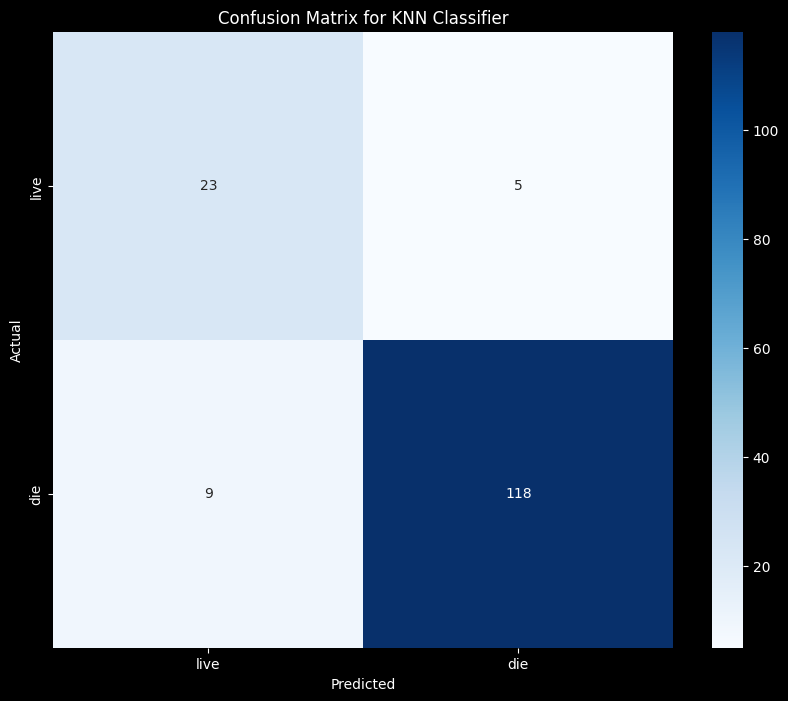

In [8]:
knn = KNNClassifier(
    k=7,
    distance_func=ManhattanDistance(),
    voting_func=InverseDistanceWeightedVote(),
    weights=np.ones(len(train_dfs[0].columns) - 1),
)
scores = cross_validate(
    knn,
    train_dfs,
    test_dfs,
    target_col="Class",
    score_func=partial(confusion_matrix),
)
sum_scores = scores.sum(axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(sum_scores, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for KNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=["live", "die"])
plt.yticks(ticks=[0.5, 1.5], labels=["live", "die"])
plt.show()


In [9]:
c_values = [1, 3, 5, 7]
kernal_types = ["linear", "poly", "rbf", "sigmoid"]

results = pd.DataFrame(
    columns=[
        "c",
        "kernel_type",
        "f1_mean",
        "f1_std",
    ]
)
for c, kernel_type in itertools.product(
    c_values, kernal_types
):
    svm = SVMClassifier(
        C=c,
        kernel=kernel_type,
    )
    scores = cross_validate(
        svm,
        train_dfs,
        test_dfs,
        target_col="Class",
        score_func=partial(f1_score, average="weighted"),
    )
    results.loc[len(results)] = [
        c,
        kernel_type,
        scores.mean(),
        scores.std(),
    ]

results.sort_values(by="f1_mean", ascending=False)

,c,kernel_type,f1_mean,f1_std
14,7,rbf,0.965924,0.066709
10,5,rbf,0.959588,0.066178
6,3,rbf,0.954239,0.067746
5,3,poly,0.954043,0.068015
1,1,poly,0.954031,0.068018
9,5,poly,0.951956,0.068546
13,7,poly,0.951956,0.068546
2,1,rbf,0.920141,0.087627
4,3,linear,0.890127,0.056311
0,1,linear,0.889518,0.071931


In [10]:
svm = SVMClassifier(
    C=5,
    kernel="linear",
)
y_actuals, y_preds = cross_validate(
        svm,
        train_dfs,
        test_dfs,
    target_col="Class",
)

confusion_matrix = confusion_matrix(y_actuals, y_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for SVM Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.yticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.show()


ValueError: too many values to unpack (expected 2)

In [ ]:
sensitivity = sum_scores[0, 0] / (sum_scores[0, 0] + sum_scores[1, 0])
specificity = sum_scores[1, 1] / (sum_scores[1, 1] + sum_scores[0, 1])
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Create and train the SVM classifier
svm = SVMClassifier(C=5, kernel="linear", probability=True)
y_true, y_scores = cross_validate(svm, train_dfs, test_dfs, "Class", use_proba=True)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])
average_precision = average_precision_score(y_true, y_scores[:, 1])

# Plot the precision-recall curve
plt.figure(figsize=(10, 8))
plt.step(recall, precision, alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: AP={average_precision:.2f}')
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

# Create and calibrate the SVM classifier
base_svm = SVMClassifier(C=5, kernel="linear")
calibrated_svm = CalibratedClassifierCV(base_svm, cv=5, method='sigmoid')

# Get predictions and true labels
y_true, y_scores = cross_validate(calibrated_svm, train_dfs, test_dfs, "Class", use_proba=True)

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores[:, 1])

# Find the threshold that gives the highest recall while maintaining at least 90% recall
target_recall = 0.9
valid_thresholds = thresholds[:][recall[1:] >= target_recall]
if len(valid_thresholds) > 0:
    recall_threshold = valid_thresholds[-1]
else:
    recall_threshold = thresholds[-1]  # If no threshold gives 90% recall, use the lowest threshold

# Get predictions with the new threshold
y_preds_high_recall = (y_scores[:, 1] >= recall_threshold).astype(int)

# Calculate metrics
high_recall = recall_score(y_true, y_preds_high_recall)
precision = precision_score(y_true, y_preds_high_recall)
f1 = f1_score(y_true, y_preds_high_recall)

print(f"Threshold for high recall: {recall_threshold:.3f}")
print(f"Recall: {high_recall:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1 Score: {f1:.2%}")

# Print classification report for the high-recall model
print(classification_report(y_true, y_preds_high_recall))


# Pre-Analysis

In [ ]:
preds = []
actuals = []

for train_df, test_df in zip(train_dfs, test_dfs):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df.drop("Class", axis=1), train_df["Class"])
    preds.extend(decision_tree.predict(test_df.drop("Class", axis=1)))
    actuals.extend(test_df["Class"])

print(classification_report(actuals, preds))

It looks like a decision tree is not able to learn the data well, possibly because the 0th class is a minority class.

In [ ]:
feature_importances = pd.DataFrame(
    {
        "feature": train_dfs[0].drop("Class", axis=1).columns,
        "importance": decision_tree.feature_importances_,
        "index": range(len(decision_tree.feature_importances_)),
    }
)
top_5_features = feature_importances.sort_values("importance", ascending=False).head(5)
print("Top 5 features:")
top_5_features

In [ ]:
pd.plotting.scatter_matrix(
    pd.concat(train_dfs + test_dfs)[top_5_features.feature.values.tolist() + ["Class"]],
    figsize=(12, 12),
)
plt.show()

In [ ]:
import seaborn as sns

top_5_features_and_class = top_5_features["feature"].tolist() + ["Class"]
corr_matrix = pd.concat(train_dfs + test_dfs)[top_5_features_and_class].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Top 5 Features")
plt.show()